# Unbuffered backtest

In [1]:
# Load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf   # falls back to sample cov below
import statsmodels.api as sm

path = "C:/Users/itataurov.KORECAPITAL/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path, engine='pyarrow')
df = df.sort_values(by=['datetime'])
first_idx = df['fundingRate'].first_valid_index() # important to see when stuff began trading
df = df.loc[first_idx:]
df = df[df.datetime>'2021-01-01']
df = df[df.datetime<'2025-01-01']

HORIZON = 30

In [2]:
df.columns

Index(['symbol', 'datetime', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume'],
      dtype='object')

<Axes: xlabel='datetime'>

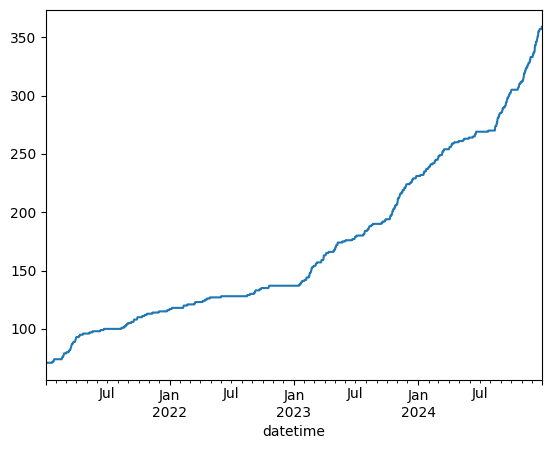

In [3]:
# universe size over time
df.groupby('datetime')['symbol'].nunique().plot()

In [4]:
import signals

# Signal generation
def compute_signal(df: pd.DataFrame) -> pd.DataFrame:
	df = signals._compute_buy_volume_ratio(df, 'buy_volume_ratio', 32)
	df = signals._compute_ls_ratio(df, 'ls_ratio', 32)
	df = signals._compute_carry(df, 'carry', 32)

	return df

# ── Universe filtering ──────────────────────────────────────────────────────
def filter_universe(df: pd.DataFrame) -> pd.DataFrame:
	"""
	Filter out illiquids and newly listed coins.
	"""

	df = df[df.dollar_volume_slowed >= 5e6] # at least $5M daily volume 
	df = df[df.days_since_listing >= 90] # at least 90 days since listing (need data for risk estimate)
	return df

# Data preparation
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
	df = df.sort_values(['datetime', 'symbol'])
	df['return'] = df.groupby('symbol')['close'].transform(lambda x: x.pct_change())

	# 1) Calculate volatility
	df['vol_expanding_window'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .expanding(min_periods=30)
					  .std())
	)
	df['vol_ewm'] = (
		df.groupby('symbol')['return']
		  .transform(lambda x: x
					  .ewm(span=30, adjust=False, min_periods=30)
					  .std())
	)
	df['volatility'] = (
		df['vol_expanding_window'] * 0.5 +
		df['vol_ewm'] * 0.5
	)

	# 2) filter universe
	df['dollar_volume'] = df['close'] * df['volume']
	df['dollar_volume_slowed'] = (
		df.groupby('symbol')['dollar_volume']
		  .transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['dv_rank'] = (
		df.groupby('datetime')['dollar_volume_slowed']
		  .rank(method='first', ascending=False)
	)
	df['dv_decile'] = df.groupby('datetime')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
	)
	df['mc_rank'] = (
		df.groupby('datetime')['market_cap_slowed']
			.rank(method='first', ascending=False)
	)
	df['mc_decile'] = df.groupby('datetime')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

	# 1) how many observations each symbol has accumulated up to *and incl.* the row
	df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

	return df#.drop(columns=['vol_expanding_window', 'vol_ewm'])

# TODO: Add funding returns to target 
def add_prediction_target(df: pd.DataFrame) -> pd.DataFrame:
	df = df.copy()
	df = df.sort_values(['datetime'])
	# demean within each date
	df['target'] = df.groupby('datetime')['fwd_return'].transform(lambda x: x - x.mean())
	return df.drop(columns=['forward_price', 'fwd_return'])

# Caclculate before uni filtering
df['forward_price'] = df.groupby('symbol')['close'].shift(-HORIZON)
df['fwd_return'] = (df['forward_price'] - df['close']) / df['close']

print("Preparing data...")
df = prepare_data(df)

print("Computing signal...")
df = compute_signal(df)

print("Filtering universe...")
df = filter_universe(df)

print("Adding prediction target...")
df = add_prediction_target(df)

# winsorize signals by date
for signal in ['buy_volume_ratio', 'ls_ratio', 'carry']:
	df[signal] = df.groupby('datetime')[signal].transform(lambda x: x.clip(x.quantile(0.05), x.quantile(0.95)))

df


Preparing data...
Computing signal...
Computing buy volume ratio signal...
Computing long–short ratio signal...
Computing funding rate momentum signal...
Filtering universe...
Adding prediction target...


,symbol,datetime,open,high,low,close,volume,mkt_cap,fundingRate,oi,...,dv_rank,dv_decile,market_cap_slowed,mc_rank,mc_decile,days_since_listing,buy_volume_ratio,ls_ratio_ewm,carry,target
20311,1INCH,2021-04-01,4.344400,4.533900,4.253700,4.460600,14490755.0,NaN,0.003538,NaN,...,29.0,7.0,NaN,NaN,NaN,90,0.462874,5.925700,0.025788,-0.168166
20381,SNX,2021-04-01,17.693000,19.431000,17.632000,19.206000,2782391.5,2.411015e+09,0.004446,NaN,...,63.0,3.0,2.347651e+09,24.0,7.0,90,0.473763,3.385067,0.034651,-0.459582
20380,SKL,2021-04-01,0.752120,0.824600,0.720000,0.816680,106781335.0,4.606508e+08,0.004734,NaN,...,40.0,6.0,2.748150e+08,54.0,2.0,90,0.476115,2.959281,0.021577,-0.601645
20376,RUNE,2021-04-01,7.959600,8.955000,7.957900,8.340300,8303806.0,0.000000e+00,0.002288,NaN,...,72.0,2.0,0.000000e+00,66.0,1.0,90,0.469191,2.444681,0.019473,0.450204
20375,RSR,2021-04-01,0.090032,0.091795,0.084801,0.088243,467587452.0,3.706845e+08,0.004858,NaN,...,46.0,5.0,2.826469e+08,51.0,3.0,90,0.468058,3.688211,0.027491,-0.374163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262970,EIGEN,2024-12-31,3.670800,3.851100,3.463100,3.517800,38980671.2,6.548791e+08,0.000219,4.029413e+07,...,48.0,9.0,NaN,NaN,NaN,92,0.484368,2.060230,0.004910,NaN
262969,EGLD,2024-12-31,34.301000,35.179000,33.026000,33.437000,415161.8,4.518378e+08,0.000300,9.757355e+06,...,185.0,5.0,5.006956e+08,92.0,7.0,1460,0.477185,2.440998,0.007184,NaN
262968,EDU,2024-12-31,0.530400,0.545700,0.518000,0.525700,10433287.0,NaN,0.000300,5.918918e+06,...,257.0,3.0,NaN,NaN,NaN,612,0.475335,2.946273,0.007621,NaN
262939,CHR,2024-12-31,0.238900,0.241500,0.222700,0.232300,58700697.0,1.934000e+08,0.000283,4.443076e+06,...,226.0,4.0,2.075113e+08,148.0,5.0,1391,0.477889,2.296064,0.005401,NaN


<Axes: xlabel='datetime'>

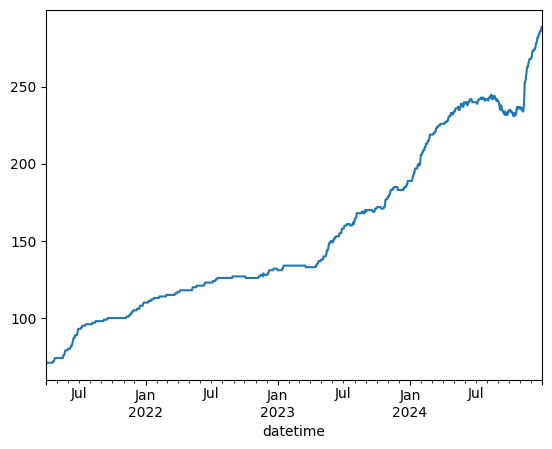

In [5]:
# universe size over time
df.groupby('datetime')['symbol'].nunique().plot()

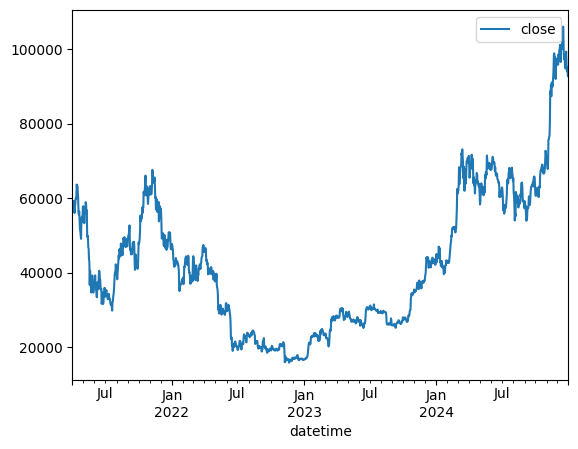

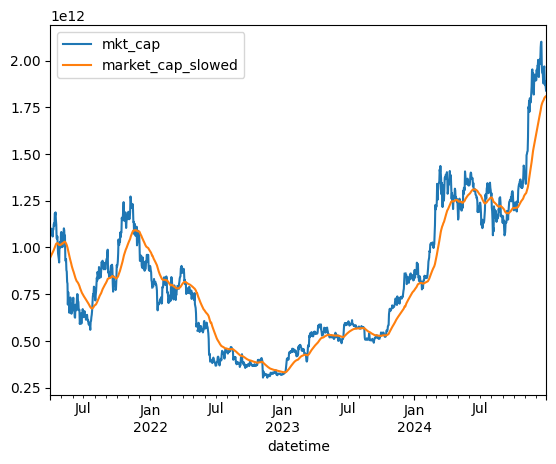

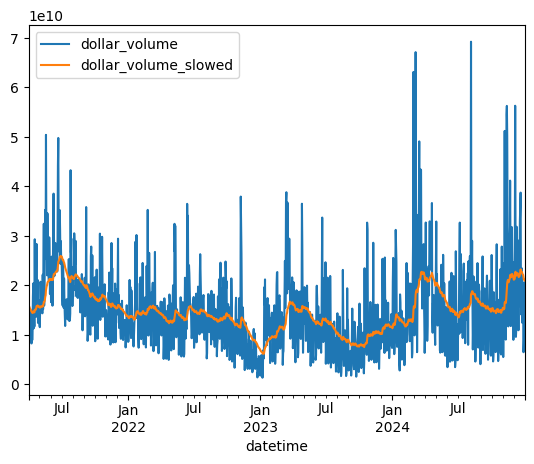

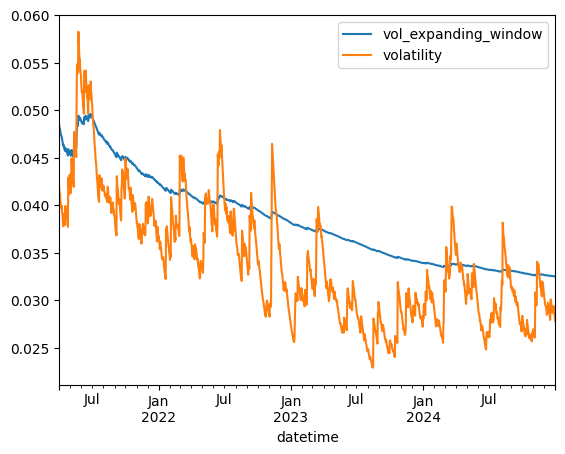

In [6]:
btc = df[df['symbol']=='BTC'].set_index('datetime')
btc['close'].plot()
plt.legend()
plt.show()

btc[['mkt_cap', 'market_cap_slowed']].plot()
plt.legend()
plt.show()

btc[['dollar_volume', 'dollar_volume_slowed']].plot()
plt.legend()
plt.show()

btc[['vol_expanding_window','volatility']].plot()
plt.legend()
plt.show()

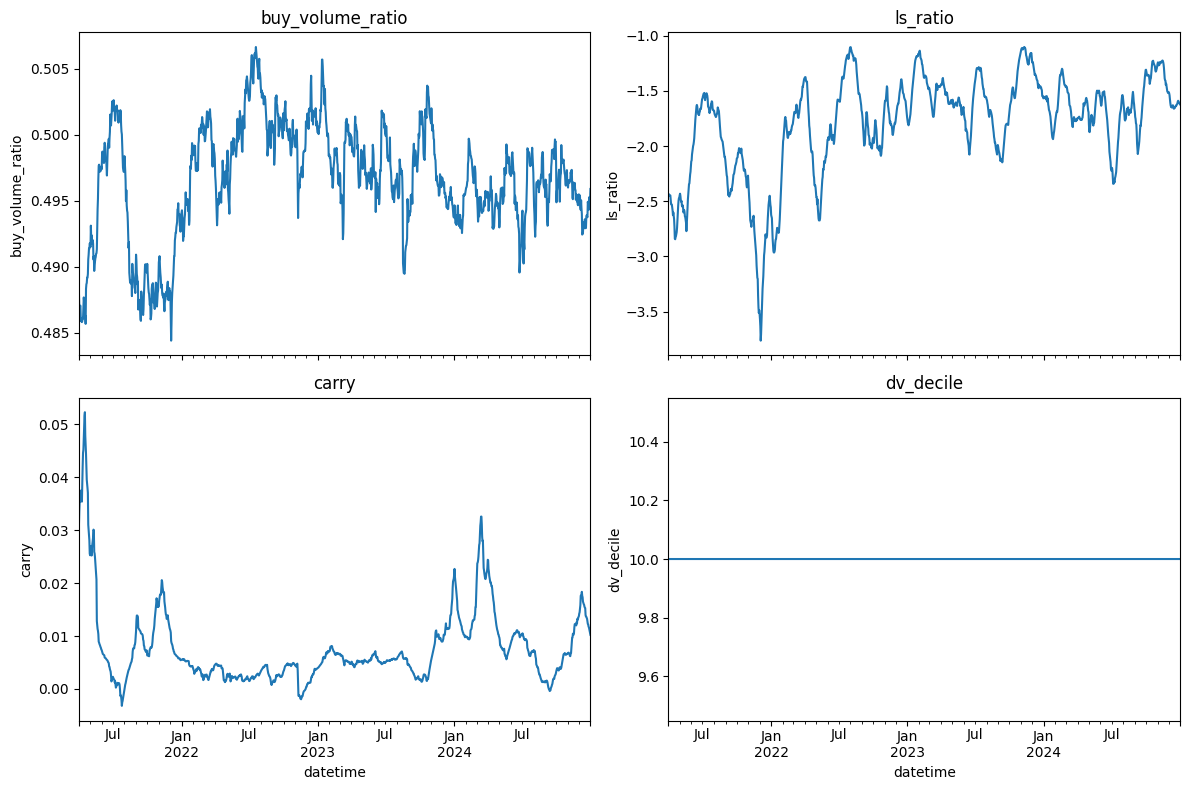

In [7]:
import matplotlib.pyplot as plt

signals = [
    "buy_volume_ratio",
    "ls_ratio",
    "carry",
    "dv_decile"
]

n = len(signals)
ncols = 2
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8), sharex=True)
axes = axes.flatten()

for ax, sig in zip(axes, signals):
    btc[sig].plot(ax=ax, title=sig)
    ax.set_ylabel(sig)

# Hide unused axes if signals doesn’t fill the grid
for ax in axes[n:]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

# Visual check

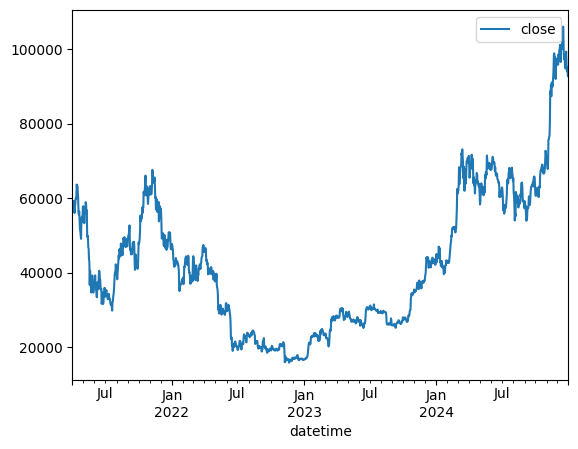

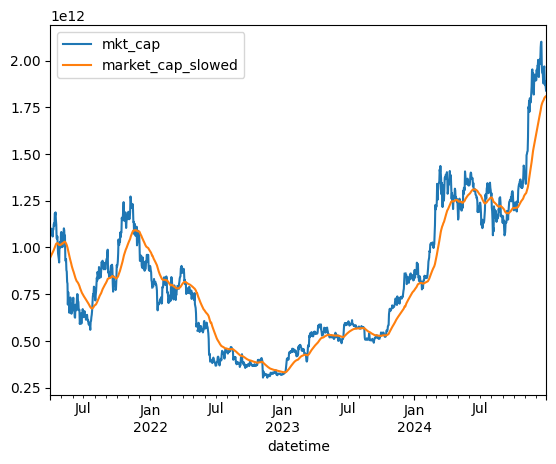

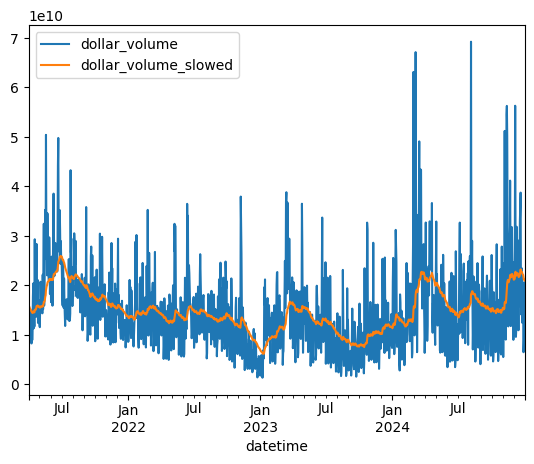

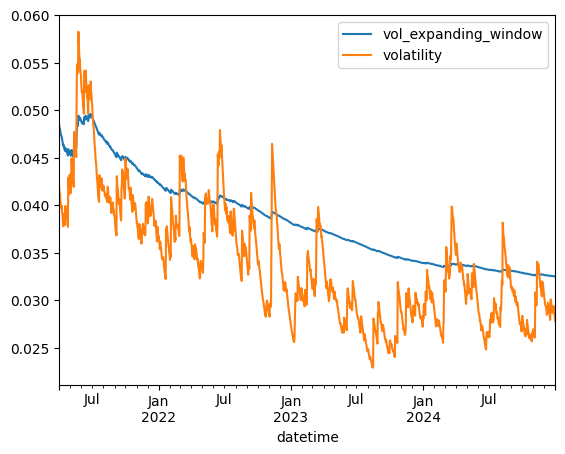

In [8]:
btc = df[df['symbol']=='BTC'].set_index('datetime')
btc['close'].plot()
plt.legend()
plt.show()

btc[['mkt_cap', 'market_cap_slowed']].plot()
plt.legend()
plt.show()

btc[['dollar_volume', 'dollar_volume_slowed']].plot()
plt.legend()
plt.show()

btc[['vol_expanding_window','volatility']].plot()
plt.legend()
plt.show()

# OLS forecast


In [9]:
def purged_embargoed_cv_metrics(
    df_sub,                       # already filtered to <= last_training_date
    predictors,
    interactions,
    inter_names,
    n_splits=5,
    embargo_days=5,
    min_train_days=30
):
    dates = np.sort(df_sub['datetime'].unique())
    if len(dates) < n_splits + 1:
        return {'pearson': np.nan, 'spearman': np.nan, 'r2': np.nan, 'mse': np.nan, 'n': 0}

    blocks = np.array_split(dates, n_splits)
    y_true_list, y_pred_list = [], []

    for b in range(n_splits):
        test_dates = blocks[b]
        test_start = test_dates[0]

        # Purge: only use dates < test_start; Embargo: drop the prior embargo_days window
        cutoff = test_start - pd.Timedelta(days=embargo_days)
        train_dates = dates[dates < cutoff]
        if len(train_dates) < min_train_days:
            continue

        tr = df_sub[df_sub['datetime'].isin(train_dates)][predictors + ['target']].copy()
        te = df_sub[df_sub['datetime'].isin(test_dates)][predictors + ['target']].copy()
        if tr.empty or te.empty:
            continue

        # Standardize on TRAIN only
        mu = tr[predictors].mean()
        sig = tr[predictors].std().replace(0, np.nan)

        X_tr = (tr[predictors] - mu) / sig
        X_te = (te[predictors] - mu) / sig

        # Interactions on standardized features
        for (f1, f2), name in zip(interactions, inter_names):
            X_tr[name] = X_tr[f1] * X_tr[f2]
            X_te[name] = X_te[f1] * X_te[f2]

        # Drop rows with NaNs in X or y
        Xy_tr = pd.concat([X_tr[predictors + inter_names], tr['target']], axis=1).dropna()
        Xy_te = pd.concat([X_te[predictors + inter_names], te['target']], axis=1).dropna()
        if Xy_tr.empty or Xy_te.empty:
            continue

        y_tr = Xy_tr['target']
        X_tr_dm = sm.add_constant(Xy_tr[predictors + inter_names], has_constant='add')

        # Need more rows than parameters
        if len(X_tr_dm) <= X_tr_dm.shape[1]:
            continue

        res = sm.OLS(y_tr, X_tr_dm).fit()

        X_te_dm = sm.add_constant(Xy_te[predictors + inter_names], has_constant='add')
        y_pred = pd.Series(res.predict(X_te_dm).values, index=Xy_te.index)
        y_true = Xy_te['target']

        y_true_list.append(y_true)
        y_pred_list.append(y_pred)

    if not y_true_list:
        return {'pearson': np.nan, 'spearman': np.nan, 'r2': np.nan, 'mse': np.nan, 'n': 0}

    y_true = pd.concat(y_true_list)
    y_pred = pd.concat(y_pred_list).reindex_like(y_true)

    valid = ~(y_true.isna() | y_pred.isna())
    y_true, y_pred = y_true[valid], y_pred[valid]
    n = len(y_true)

    pearson = y_true.corr(y_pred) if n > 1 else np.nan
    spearman = y_true.rank().corr(y_pred.rank()) if n > 1 else np.nan
    mse = float(np.mean((y_true - y_pred) ** 2)) if n > 0 else np.nan

    ss_res = float(np.sum((y_true - y_pred) ** 2))
    ss_tot = float(np.sum((y_true - y_true.mean()) ** 2))
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

    return {'pearson': pearson, 'spearman': spearman, 'r2': r2, 'mse': mse, 'n': n}


In [38]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

metrics_over_time = []  # store metrics for each date
betas = []  

# def compute_signal(df: pd.DataFrame) -> pd.DataFrame:
# 	df = signals._compute_buy_volume_ratio(df, 'buy_volume_ratio', 32)
# 	df = signals._compute_bolmom(df, 'bolmom', 32)
# 	df = signals._compute_funding_volatility(df, 'funding_volatility', 32)
# 	df = signals._compute_ls_ratio(df, 'ls_ratio', 32)

# 	df['log_tt'] = np.log(df['total_trades_perp'])
# 	df['tt_2p_ewm'] = (
# 		df.groupby('symbol')['log_tt']
# 		.transform(lambda x: x.ewm(span=32, min_periods=1).mean())
# 	)

predictors = ['ls_ratio','buy_volume_ratio', 'carry', 'dv_decile']
interactions = [('ls_ratio', 'dv_decile'), ('buy_volume_ratio', 'dv_decile'), ('carry', 'dv_decile')]
inter_names = [f'{a}_x_{b}' for a,b in interactions]

dates = np.sort(df['datetime'].unique())

for date in dates[30:]:
    print(f"Processing date: {date}")
    # Expanding train up to (date - Horizon days)
    last_training_date = date - pd.Timedelta(days=HORIZON)
    df_train = df.loc[(df['datetime'] <= last_training_date) , predictors + ['target', 'datetime']].copy()
    if df_train.empty:
        continue

    # --- NEW: CV on the training window (purged + embargoed) ---
    # cv = purged_embargoed_cv_metrics(
    #     df_sub=df_train,
    #     predictors=predictors,
    #     interactions=interactions,
    #     inter_names=inter_names,
    #     n_splits=5,
    #     embargo_days=HORIZON,      # match your embargo
    #     min_train_days=30    # adjust as you like
    # )
    
    # metrics_over_time.append({
    #     "date": date,
    #     **cv
    # })
    df_train.drop(columns=['datetime'], inplace=True)

    # Standardize on TRAIN only
    mu = df_train[predictors].mean()
    sig = df_train[predictors].std()
    sig = sig.replace(0, np.nan)  # avoid div-by-zero
    X_train = (df_train[predictors] - mu) / sig

    # Interactions (on standardized features)
    for (f1, f2), name in zip(interactions, inter_names):
        X_train[name] = X_train[f1] * X_train[f2]
    
    # Build design matrix and drop rows with NaNs
    Xy = pd.concat([X_train[predictors + inter_names], df_train['target']], axis=1).dropna()
    if Xy.empty:
        continue

    y = Xy['target']
    X = sm.add_constant(Xy[predictors + inter_names], has_constant='add')

    # Require enough rows to fit
    if len(X) <= X.shape[1]:
        continue

    results = sm.OLS(y, X).fit()

    betas.append({
        "date": date,
        **results.params.to_dict()
    })

    # Predict on this date (standardize with TRAIN mu/sigma)
    mask_date = df['datetime'].eq(date)
    X_pred = df.loc[mask_date, predictors].copy()
    X_pred = (X_pred - mu) / sig
    for (f1, f2), name in zip(interactions, inter_names):
        X_pred[name] = X_pred[f1] * X_pred[f2]
    X_pred = sm.add_constant(X_pred[predictors + inter_names], has_constant='add')

    preds = results.predict(X_pred)
    df.loc[mask_date, 'forecast'] = preds.values

    print(f"Date: {date}, Symbols: {mask_date.sum()}, R²: {results.rsquared:.4f}")


Processing date: 2021-05-01T00:00:00.000000000
Date: 2021-05-01T00:00:00.000000000, Symbols: 74, R²: 0.0946
Processing date: 2021-05-02T00:00:00.000000000
Date: 2021-05-02T00:00:00.000000000, Symbols: 74, R²: 0.0963
Processing date: 2021-05-03T00:00:00.000000000
Date: 2021-05-03T00:00:00.000000000, Symbols: 74, R²: 0.0919
Processing date: 2021-05-04T00:00:00.000000000
Date: 2021-05-04T00:00:00.000000000, Symbols: 74, R²: 0.0912
Processing date: 2021-05-05T00:00:00.000000000
Date: 2021-05-05T00:00:00.000000000, Symbols: 74, R²: 0.0903
Processing date: 2021-05-06T00:00:00.000000000
Date: 2021-05-06T00:00:00.000000000, Symbols: 74, R²: 0.0904
Processing date: 2021-05-07T00:00:00.000000000
Date: 2021-05-07T00:00:00.000000000, Symbols: 74, R²: 0.0928
Processing date: 2021-05-08T00:00:00.000000000
Date: 2021-05-08T00:00:00.000000000, Symbols: 74, R²: 0.0953
Processing date: 2021-05-09T00:00:00.000000000
Date: 2021-05-09T00:00:00.000000000, Symbols: 74, R²: 0.0953
Processing date: 2021-05-10T

# Betas

Average Betas:
const              -0.001663
ls_ratio           -0.005037
buy_volume_ratio    0.018287
carry              -0.004709
dv_decile          -0.011039
dtype: float64
Last betas:  const              -0.002145
ls_ratio           -0.005773
buy_volume_ratio    0.012784
carry               0.002640
dv_decile          -0.013887
Name: 1340, dtype: float64


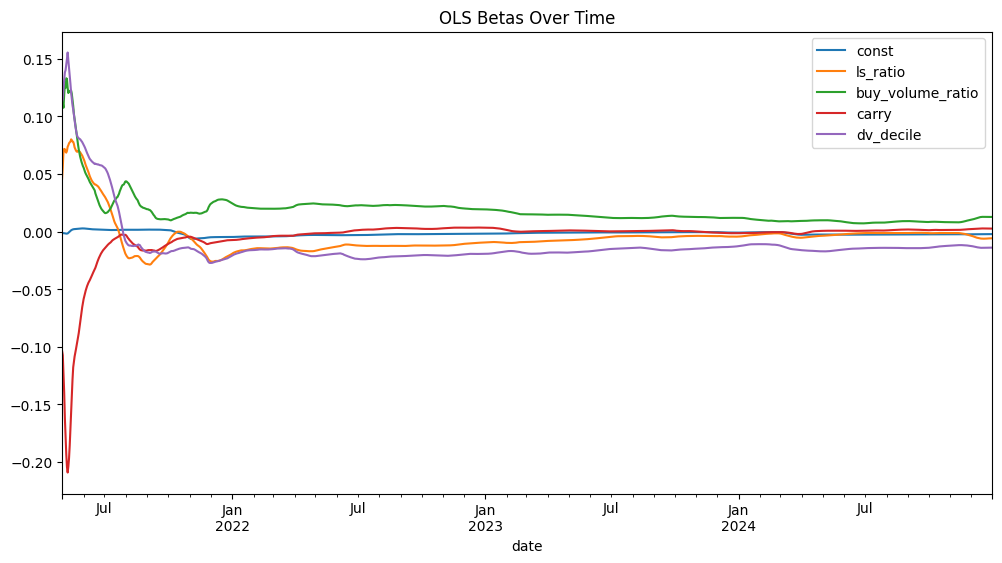

In [39]:
betas_df = pd.DataFrame(betas)

# --- Plotting ---
betas_df.set_index('date').plot(figsize=(12, 6))
plt.title("OLS Betas Over Time")   

print("Average Betas:")
print(betas_df.drop(columns='date').mean())

print("Last betas: ", betas_df.drop(columns='date').iloc[-1])

# CV metrics

In [40]:
# Convert metrics_over_time to DataFrame and set index
metrics_df = pd.DataFrame(metrics_over_time).set_index("date")
# metrics_df = metrics_df.ewm(span=90).mean()  # Optional: smooth with EWMA

KeyError: "None of ['date'] are in the columns"

NameError: name 'metrics_df' is not defined

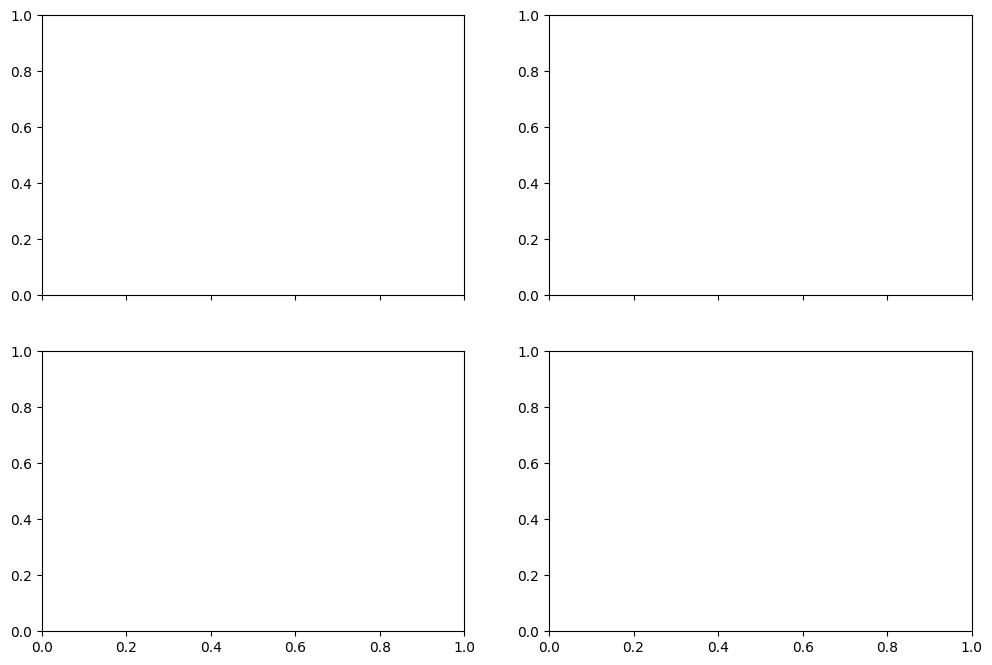

In [ ]:
from scipy.stats import spearmanr

# --- Compute realized metrics (forecast vs target) day by day ---
realized = []
for date, grp in df.groupby("datetime"):
    if grp["forecast"].notna().any() and grp["target"].notna().any():
        y_true = grp["target"]
        y_pred = grp["forecast"]

        # drop NaNs and align
        mask = ~(y_true.isna() | y_pred.isna())
        if mask.sum() == 0:
            continue
        y_true, y_pred = y_true[mask], y_pred[mask]

        pearson = y_true.corr(y_pred)
        spearman = spearmanr(y_true, y_pred).correlation
        mse = ((y_true - y_pred) ** 2).mean()
        ss_res = ((y_true - y_pred) ** 2).sum()
        ss_tot = ((y_true - y_true.mean()) ** 2).sum()
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else np.nan

        realized.append({
            "date": date,
            "pearson": pearson,
            "spearman": spearman,
            "r2": r2,
            "mse": mse,
        })

realized_df = pd.DataFrame(realized).set_index("date")
realized_df = realized_df.ewm(span=90).mean()

# --- Plot CV vs realized side by side ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

metrics_df["pearson"].plot(ax=axes[0,0], label="CV")
realized_df["pearson"].plot(ax=axes[0,0], label="Realized (EWMA)", color="orange")
axes[0,0].set_title("Pearson correlation")

metrics_df["spearman"].plot(ax=axes[0,1], label="CV")
realized_df["spearman"].plot(ax=axes[0,1], label="Realized (EWMA)", color="orange")
axes[0,1].set_title("Spearman correlation")

metrics_df["r2"].plot(ax=axes[1,0], label="CV")
realized_df["r2"].plot(ax=axes[1,0], label="Realized (EWMA)", color="orange")
axes[1,0].set_title("R²")

metrics_df["mse"].plot(ax=axes[1,1], label="CV")
realized_df["mse"].plot(ax=axes[1,1], label="Realized (EWMA)", color="orange")
axes[1,1].set_title("MSE")

for ax in axes.flat:
    ax.axhline(0, color="gray", linestyle="--", linewidth=0.7)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend()

plt.suptitle("Purged+Embargoed CV vs Realized Metrics Over Time", fontsize=14)
plt.tight_layout()
plt.show()

print("Average CV Metrics:")
print(metrics_df.mean())

print("Average Realized Metrics:")
print(realized_df.mean())


# Model eval


In [41]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

# Evaluate forecast vs target
def evaluate_forecast(df, target_col="target", forecast_col="forecast"):
    y_true = df[target_col].values
    y_pred = df[forecast_col].values
    
    # Pearson correlation
    pearson_corr, _ = pearsonr(y_true, y_pred)
    # Spearman correlation
    spearman_corr, _ = spearmanr(y_true, y_pred)
    
    metrics = {
        "Pearson R2": pearson_corr**2,
        "Pearson": pearson_corr,
        "Spearman": spearman_corr
    }
    return pd.Series(metrics)

# Example usage (drops NaNs first):
results = evaluate_forecast(df[["target", "forecast"]].dropna())
print(results)


Pearson R2    0.000010
Pearson       0.003103
Spearman      0.046071
dtype: float64


Not bad for 1 feature, ic of 1%

Regular bolmom

Pearson R2    0.000002
Pearson       0.001247
Spearman      0.019468

Vol-normalized bolmom
Pearson R2    0.000002
Pearson       0.001377
Spearman      0.031084
dtype: float64


ls ratio
Pearson R2    0.000013
Pearson       0.003608
Spearman      0.039137

ls ratio / volatility
Pearson R2    0.000007
Pearson      -0.002563
Spearman      0.028743

ls ratio / volatility**2

dtype: float64


# Portfolio construction

In [42]:
# Pivot for backtest inputs
def pivot_data(df: pd.DataFrame):
	forecast = df.pivot(index='datetime', columns='symbol', values='forecast')
	returns = df.pivot(index='datetime', columns='symbol', values='return')
	funding = df.pivot(index='datetime', columns='symbol', values='fundingRate')
	volatility = df.pivot(index='datetime', columns='symbol', values='volatility')

	return forecast, returns, funding, volatility

forecast, returns, funding, volatility = pivot_data(df)

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf

# ---------- MV optimizer ----------
def mv_optimize(alpha: pd.Series, cov: pd.DataFrame,
                gamma: float = 1.0, ridge_lambda: float = 0.0) -> pd.Series:
    symbols = alpha.index.intersection(cov.index)
    alpha = alpha.loc[symbols]
    C = cov.loc[symbols, symbols].values

    # --- Ridge regularization (scale by avg variance to make λ unit-aware) ---
    if ridge_lambda > 0:
        avg_var = float(np.mean(np.diag(C)))
        C = C + ridge_lambda * avg_var * np.eye(len(symbols))

    try:
        invC = np.linalg.pinv(C, rcond=1e-8)  # or np.linalg.solve if you keep the dense inverse out
        raw_w = invC @ alpha.values
    except Exception:
        raw_w = np.zeros_like(alpha.values)

    w = pd.Series(gamma * raw_w, index=symbols)

    # Dollar-neutral & unit gross
    w = w - w.mean()
    s = w.abs().sum()
    if s > 0:
        w /= s
    return w


# ---------- Unified portfolio construction with diagnostics ----------
def compute_weights(alpha_forecast: pd.DataFrame,
                    returns: pd.DataFrame,
                    method: str = "stupid",
                    lag: bool = True,
                    inertia: float = 0.0,
                    window: int = 180,
                    gamma: float = 1.0,
                    ridge_lambda: float = 0.0  
                   ):
    weights_list = []

    # --- Diagnostics arrays ---
    min_eigs, max_eigs, cond_nums, avg_corrs = [], [], [], []
    diag_dates = []

    for date in alpha_forecast.index:
        print(date)
        alpha = alpha_forecast.loc[date]

        if method == "stupid": # systematic ls style
            adj = alpha - alpha.mean()
            w = adj / adj.abs().sum() if adj.abs().sum() > 0 else adj * 0

        elif method == "mv":
            past_returns = returns.loc[:date].iloc[-window:]
            if past_returns.shape[0] < 30:
                print("Not enough data for covariance estimation, skipping date.")
                w = pd.Series(0.0, index=alpha.index)
            else:
                lw = LedoitWolf().fit(past_returns.dropna(axis=1))
                cov = pd.DataFrame(lw.covariance_,
                   index=past_returns.dropna(axis=1).columns,
                   columns=past_returns.dropna(axis=1).columns)

                alpha_today = alpha.dropna()

                if alpha_today.empty or cov.empty:
                    w = pd.Series(0.0, index=alpha.index)
                else:
                    w = mv_optimize(alpha_today, cov, gamma=gamma, ridge_lambda=ridge_lambda)
                    w = w.reindex(alpha.index).fillna(0.0)

        else:
            raise ValueError("method must be 'stupid' or 'mv'")

        w.name = date
        weights_list.append(w)

    weights = pd.DataFrame(weights_list).fillna(0.0)

    if inertia > 0:
        prev_w = weights.shift(1).fillna(0.0)
        weights = inertia * prev_w + (1 - inertia) * weights

    if lag:
        weights = weights.shift(1)

    # --- Pack diagnostics into a DataFrame ---
    diag = pd.DataFrame({
        "min_eig": min_eigs,
        "max_eig": max_eigs,
        "cond_num": cond_nums,
        "avg_corr": avg_corrs
    }, index=diag_dates)

    return weights.fillna(0.0), diag


w_systls, cov_diag = compute_weights(forecast, returns, method="stupid", lag=True, inertia=0.0)
w_mv, cov_diag = compute_weights(forecast, returns, method="mv", lag=True, inertia=0.0, window=180, gamma=1.0, ridge_lambda=10)

# print("Turnover (MV):", w_mv.diff().abs().sum(axis=1).mean())

# # --- Plot diagnostics ---
# fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

# cov_diag["min_eig"].plot(ax=axes[0], title="Min eigenvalue of covariance")
# axes[0].axhline(0, color="red", linestyle="--")

# cov_diag["cond_num"].plot(ax=axes[1], title="Condition number (ill-conditioned if >> 1e8)", logy=True)

# cov_diag["avg_corr"].plot(ax=axes[2], title="Average correlation")

# plt.tight_layout()
# plt.show()


2021-04-01 00:00:00
2021-04-02 00:00:00
2021-04-03 00:00:00
2021-04-04 00:00:00
2021-04-05 00:00:00
2021-04-06 00:00:00
2021-04-07 00:00:00
2021-04-08 00:00:00
2021-04-09 00:00:00
2021-04-10 00:00:00
2021-04-11 00:00:00
2021-04-12 00:00:00
2021-04-13 00:00:00
2021-04-14 00:00:00
2021-04-15 00:00:00
2021-04-16 00:00:00
2021-04-17 00:00:00
2021-04-18 00:00:00
2021-04-19 00:00:00
2021-04-20 00:00:00
2021-04-21 00:00:00
2021-04-22 00:00:00
2021-04-23 00:00:00
2021-04-24 00:00:00
2021-04-25 00:00:00
2021-04-26 00:00:00
2021-04-27 00:00:00
2021-04-28 00:00:00
2021-04-29 00:00:00
2021-04-30 00:00:00
2021-05-01 00:00:00
2021-05-02 00:00:00
2021-05-03 00:00:00
2021-05-04 00:00:00
2021-05-05 00:00:00
2021-05-06 00:00:00
2021-05-07 00:00:00
2021-05-08 00:00:00
2021-05-09 00:00:00
2021-05-10 00:00:00
2021-05-11 00:00:00
2021-05-12 00:00:00
2021-05-13 00:00:00
2021-05-14 00:00:00
2021-05-15 00:00:00
2021-05-16 00:00:00
2021-05-17 00:00:00
2021-05-18 00:00:00
2021-05-19 00:00:00
2021-05-20 00:00:00


This is using the **sample covariance** method from pandas df.cov

It tells us that 

1) Since min E.V. is < 0 it is not positive semidefinite (PSD).
2) The condition number suggests that its also ill conditioned. (inversion is numerically unstable.)

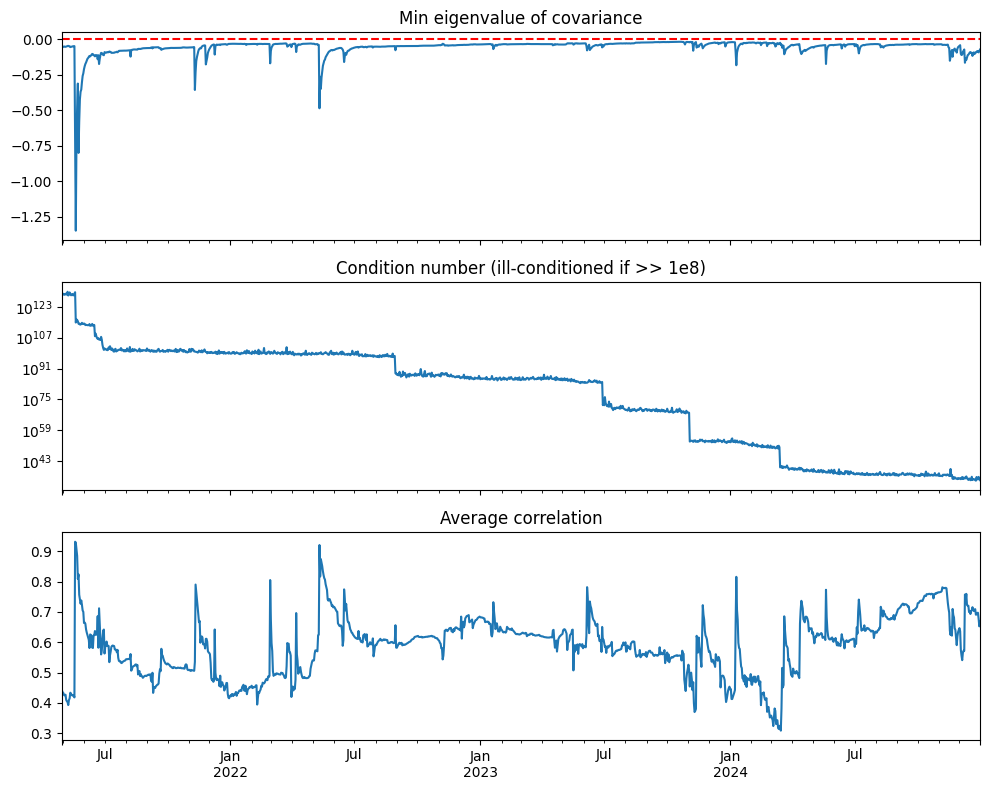

Here is ledoit wolf covariance matrix

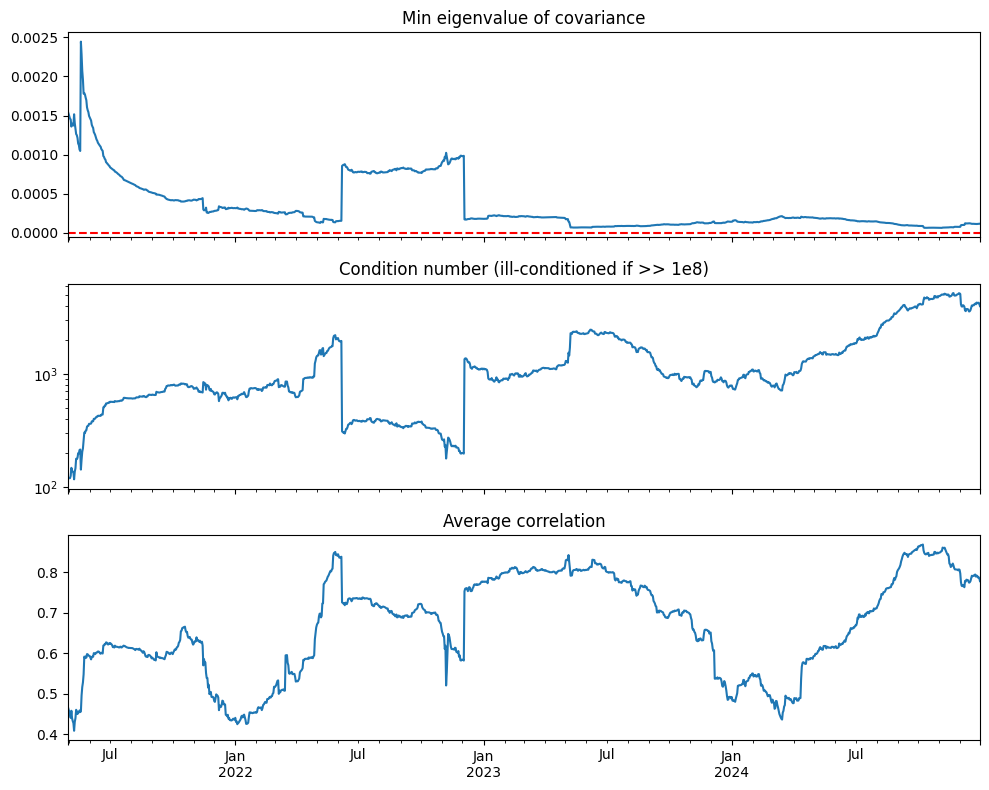

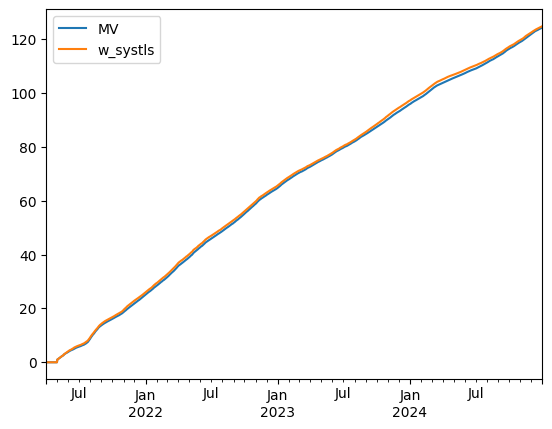

In [50]:
w_mv.diff().abs().sum(axis=1).cumsum().plot()
w_systls.diff().abs().sum(axis=1).cumsum().plot()
plt.legend(["MV","w_systls"])

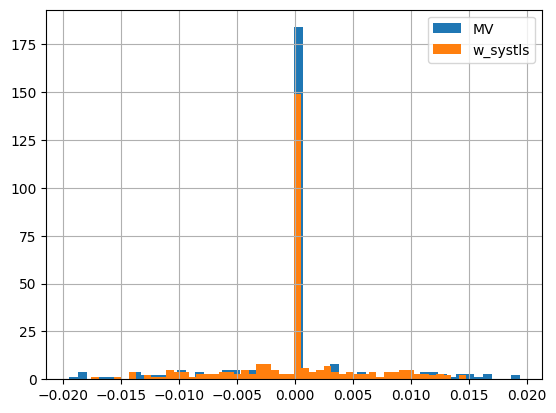

In [51]:
w_mv.iloc[-500].sort_values().hist(bins=50)
w_systls.iloc[-500].sort_values().hist(bins=50)

plt.legend(["MV", "w_systls"])

# Inspect weights

,top10_abs_sum,max_long,max_short,n_active,gross_leverage
count,1371.000000,1371.000000,1371.000000,1371.000000,1371.000000
mean,0.199749,0.025428,-0.021328,120.632385,0.977389
std,0.072430,0.011873,0.008665,40.642942,0.148715
min,0.000000,0.000000,-0.064812,0.000000,0.000000
1%,0.000000,0.000000,-0.047063,0.000000,0.000000
5%,0.122287,0.013296,-0.039834,70.000000,1.000000
50%,0.186379,0.022444,-0.019404,119.000000,1.000000
95%,0.340993,0.047837,-0.012721,186.000000,1.000000
99%,0.367273,0.062141,0.000000,195.000000,1.000000
max,0.401109,0.068342,0.000000,197.000000,1.000000


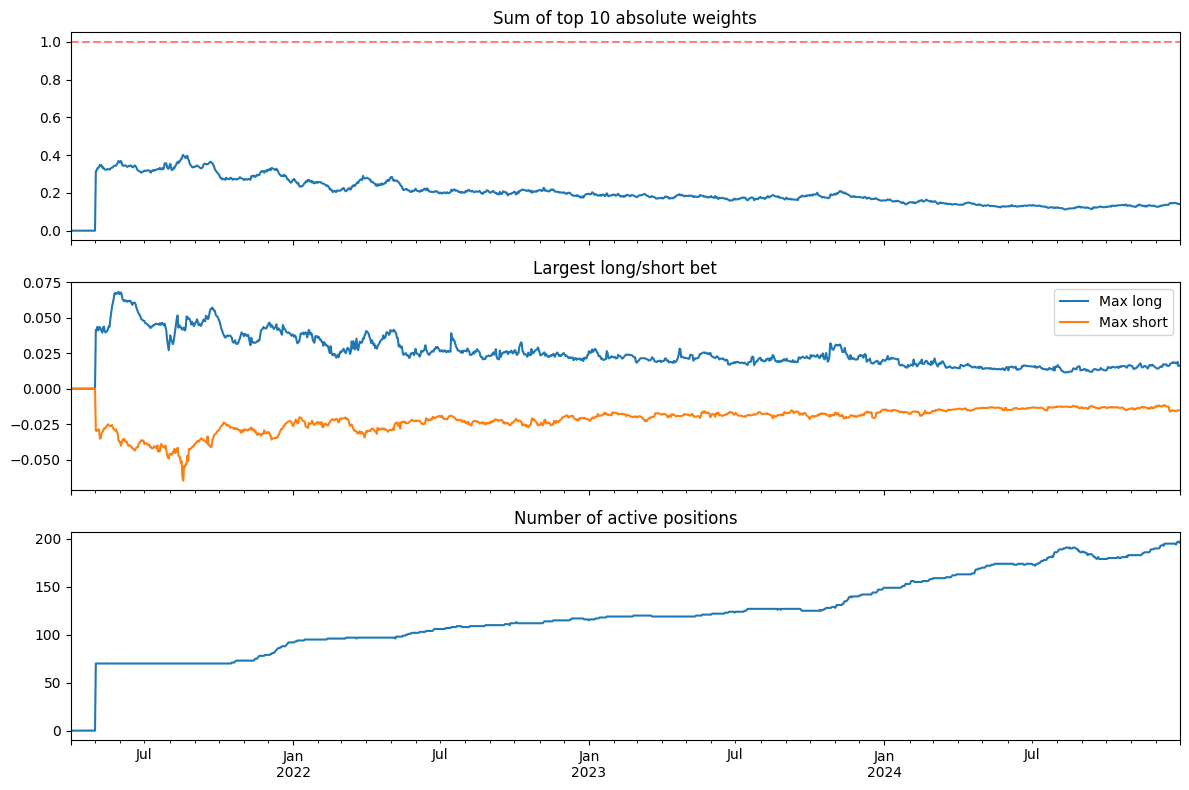

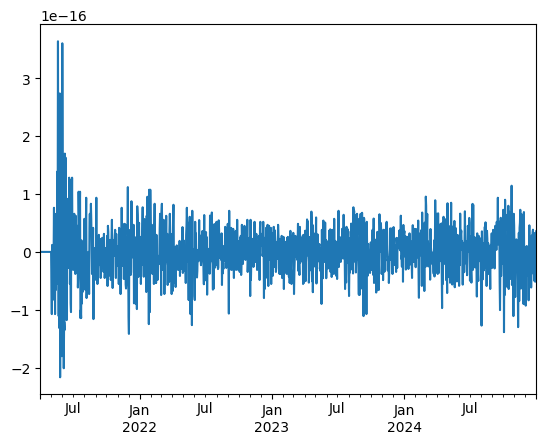

<Axes: >

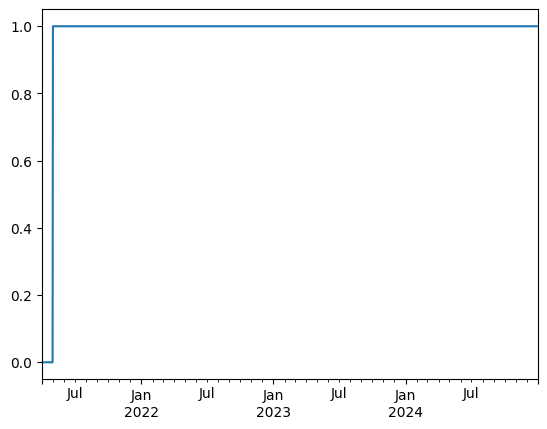

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def inspect_weights(weights: pd.DataFrame, top_n: int = 10):
    """
    Inspect portfolio weights over time.
    Shows top-N absolute weights, max long/short, and # active positions.
    """
    # Absolute weights for concentration
    top_abs = weights.abs().apply(lambda row: row.nlargest(top_n).sum(), axis=1)

    # Max long / short
    max_long = weights.max(axis=1)
    max_short = weights.min(axis=1)

    # Number of active positions
    active = (weights.abs() > 1e-6).sum(axis=1)

    summary = pd.DataFrame({
        f"top{top_n}_abs_sum": top_abs,
        "max_long": max_long,
        "max_short": max_short,
        "n_active": active,
        "gross_leverage": weights.abs().sum(axis=1)
    }, index=weights.index)

    display(summary.describe(percentiles=[0.01,0.05,0.5,0.95,0.99]))

    # --- Plots ---
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

    summary[f"top{top_n}_abs_sum"].plot(ax=axes[0], title=f"Sum of top {top_n} absolute weights")
    axes[0].axhline(1.0, color="red", linestyle="--", alpha=0.5)

    summary[["max_long","max_short"]].plot(ax=axes[1], title="Largest long/short bet")
    axes[1].legend(["Max long","Max short"])

    summary["n_active"].plot(ax=axes[2], title="Number of active positions")

    plt.tight_layout()
    plt.show()

    return summary

# Example usage:
weight_summary = inspect_weights(w_mv, top_n=10)

w_mv.sum(axis=1).plot()
plt.show()
w_mv.abs().sum(axis=1).plot()

# Vol target

In [53]:
# def vol_target_weights(raw_w: pd.DataFrame,
# 					   rets:   pd.DataFrame,
# 					   vol_target_ann: float,   # 10 % annualised
# 					   lookback: int,        # trading days
# 					   min_obs:  int      = 90) -> pd.DataFrame:
# 	"""
# 	Scale each day's weight vector so that realised σ ≈ `vol_target_ann`
# 	when estimated with a Ledoit-Wolf covariance on the past `lookback` days.

# 	Parameters
# 	----------
# 	raw_w            : DataFrame (index = timestamp, columns = symbol)
# 					   *pre-leverage* weights (dollar-neutral & |w|=1 already)
# 	rets             : DataFrame, same shape/order as `raw_w`
# 	vol_target_ann   : float, annualised target volatility (e.g. 0.10 = 10 %)
# 	lookback         : int, size of rolling window (calendar rows) for Σ̂
# 	min_obs          : int, minimum obs to start scaling; before that w = raw_w

# 	Returns
# 	-------
# 	scaled_w         : DataFrame of leverage-adjusted weights
# 	"""
# 	# daily target σ
# 	tgt_daily = vol_target_ann / np.sqrt(365)

# 	scaled = []
# 	for t, w in raw_w.iterrows():
# 		# slice past window *strictly up to and excluding* t
# 		end_loc = rets.index.get_loc(t)
# 		win = rets.iloc[max(0, end_loc - lookback): end_loc]
# 		win = win.dropna(axis=1, how="all").ffill()    

# 		if len(win) < min_obs:
# 			scaled.append(w)                     # not enough history yet
# 			continue

# 		# print date and fitting widow
# 		print(f"Vol target on {t.date()} using window "
# 			  f"{win.index[0].date()} to {win.index[-1].date()} "
# 			  f"({len(win)} obs, {len(win.columns)} assets)")

# 		# drop cols that are all-nan in window to keep LedoitWolf happy
# 		win = win.loc[:, win.notna().any()]

# 		# if every weight is zero (all skipped universe) just keep it
# 		if np.allclose(w, 0):
# 			scaled.append(w.reindex(raw_w.columns).fillna(0))
# 			continue

# 		# Ledoit–Wolf shrinkage; fall back if sklearn missing
# 		lw = LedoitWolf().fit(win.fillna(0))
# 		Sigma = lw.covariance_
# 		Sigma = pd.DataFrame(Sigma, index=win.columns, columns=win.columns)

# 		# align Σ to full column set, fill missing with zeros
# 		Sigma = Sigma.reindex(index=raw_w.columns, columns=raw_w.columns).fillna(0)

# 		# portfolio variance and scaling factor
# 		var_p = np.dot(w.values, np.dot(Sigma.values, w.values))
# 		if var_p <= 0:
# 			scale = 0.0
# 		else:
# 			scale = tgt_daily / np.sqrt(var_p)

# 		scaled.append(w * scale)

# 	scaled_w = pd.DataFrame(scaled, index=raw_w.index).fillna(0.0)
# 	return scaled_w


# weights_scaled = vol_target_weights(weights, returns,
# 								vol_target_ann=0.1,
# 								lookback=180)

# Backtest

In [54]:
# PnL and turnover calculation
def backtest(weights: pd.DataFrame,
			 returns: pd.DataFrame,
			 funding: pd.DataFrame,
			 cost_rate: float):
	weights = weights.fillna(0)
	return_pnl = (weights * returns).sum(axis=1)
	funding_pnl = -(weights * funding).sum(axis=1)
	total = return_pnl + funding_pnl
	turnover = weights.fillna(0).diff().abs().sum(axis=1)
	total_after_cost = total - cost_rate * turnover
	return return_pnl, funding_pnl, total_after_cost, turnover

trading_cost_rate = 0

mv_rtn_pnl, mv_fnd_pnl, mv_tot_pnl_post_cost, mv_turn = backtest(w_mv, returns, funding, trading_cost_rate)
systls_rtn_pnl, systls_fnd_pnl, systls_tot_pnl_post_cost, systls_turn = backtest(w_systls, returns, funding, trading_cost_rate)

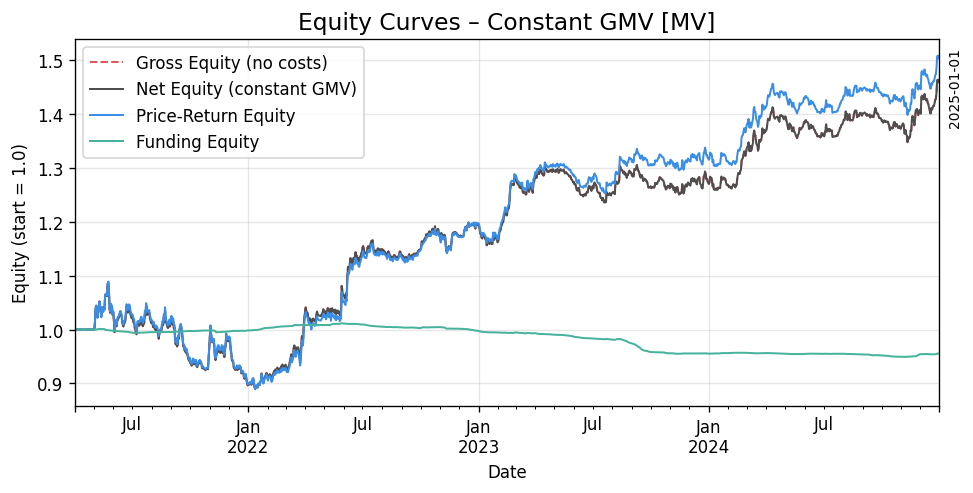

──────── Performance Summary ────────
CAGR:                           10.58%
Annualised volatility:           12.02%
Sharpe (ann.):                    1.02   95% CI [-0.23, 2.26]
Max drawdown:                  -19.86%
──────── Execution / Cost ───────────
Avg daily turnover:              9.07%
Avg holding period:              11.03 days
Average annual cost drag:          0.00 bp


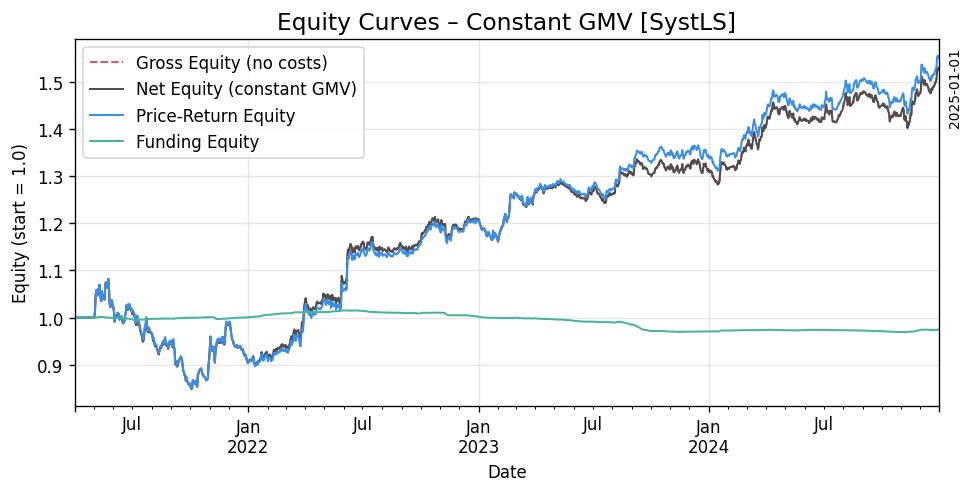

──────── Performance Summary ────────
CAGR:                           11.88%
Annualised volatility:           12.78%
Sharpe (ann.):                    1.09   95% CI [-0.19, 2.37]
Max drawdown:                  -23.38%
──────── Execution / Cost ───────────
Avg daily turnover:              9.10%
Avg holding period:              10.98 days
Average annual cost drag:          0.00 bp


In [55]:
def plot_results(return_pnl, funding_pnl, total_after_cost, strat_name="", *, highlight_date="2025-01-01"):
    # Build cumulative equity series (constant GMV, start = 1.0)
    gross_eq   = 1 + (return_pnl + funding_pnl).cumsum()
    total_eq   = 1 + total_after_cost.cumsum()
    return_eq  = 1 + return_pnl.cumsum()
    funding_eq = 1 + funding_pnl.cumsum()

    gross_eq.index   = pd.to_datetime(gross_eq.index)
    total_eq.index   = pd.to_datetime(total_eq.index)
    return_eq.index  = pd.to_datetime(return_eq.index)
    funding_eq.index = pd.to_datetime(funding_eq.index)

    # Fresh figure; constrained layout but no bbox-tight cropping
    plt.close('all')
    fig, ax = plt.subplots(figsize=(8, 4), dpi=120, constrained_layout=True)

    # Colors (Okabe–Ito-ish)
    palette = {
        "gross":   "#E15759",
        "net":     "#4E4E4E",
        "return":  "#3B8EE5",
        "funding": "#47B39C",
    }
    lw = 1.2

    gross_eq.plot(ax=ax, label="Gross Equity (no costs)",   lw=lw, ls="--", color=palette["gross"])
    total_eq.plot(ax=ax, label="Net Equity (constant GMV)", lw=lw,            color=palette["net"])
    return_eq.plot(ax=ax, label="Price-Return Equity",       lw=lw,            color=palette["return"])
    funding_eq.plot(ax=ax, label="Funding Equity",           lw=lw,            color=palette["funding"])

    # Optional vertical reference line (+ label kept INSIDE the axes)
    if highlight_date is not None:
        d = pd.to_datetime(highlight_date)
        ax.axvline(d, lw=1.6, ls=":", color="#6F6F6F", alpha=0.85, zorder=0)
        ax.annotate(
            d.strftime("%Y-%m-%d"),
            xy=(d, 1.0), xycoords=('data', 'axes fraction'),
            xytext=(5, -5), textcoords='offset points',
            rotation=90, va='top', ha='left', fontsize='small',
            annotation_clip=False   # don't clip, but stays in axes bbox
        )

    ax.set_title("Equity Curves – Constant GMV [" + strat_name + "]", fontsize=14)
    ax.set_xlabel("Date")
    ax.set_ylabel("Equity (start = 1.0)")
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Ensure the full date range is used and give a little padding
    ax.set_xlim(min(gross_eq.index.min(), total_eq.index.min()),
                max(gross_eq.index.max(), total_eq.index.max()))
    ax.margins(x=0.01, y=0.05)

    plt.show()


# ── Expanded performance report ──────────────────────────────────────────────
def report_metrics(total_after_cost, return_pnl, turnover, cost_rate):
	"""
	Prints an extended performance summary.
	"""
	import numpy as np
	import pandas as pd

	# --- core statistics -----------------------------------------------------
	mu     = total_after_cost.mean()
	sigma  = return_pnl.std()
	sharpe = mu / sigma * np.sqrt(365)

	# 95 % CI on annualised Sharpe (Jobson & Korkie, 1981)
	n   = len(total_after_cost)
	se  = np.sqrt((1 + 0.5 * sharpe**2) * 365 / n)
	ci  = sharpe - 1.96 * se, sharpe + 1.96 * se

	# --- risk-adjusted extras -----------------------------------------------
	# annualised volatility
	vol_ann = sigma * np.sqrt(365) * 100

	# CAGR of the equity curve (constant-GMV arithmetic cum-P&L)
	equity_curve = 1 + total_after_cost.cumsum()
	cagr = equity_curve.iloc[-1]**(365 / n) - 1

	# max drawdown of cumulative P&L (not compounded)
	running_max = equity_curve.cummax()
	drawdown    = equity_curve - running_max
	max_dd      = drawdown.min()      # negative number

	# turnover & cost
	avg_turnover   = turnover.mean()
	avg_hold       = 1 / avg_turnover if avg_turnover else np.inf
	cost_pnl       = -cost_rate * turnover
	cost_drag_bps  = cost_pnl.mean() * 1e4* 365   # annual cost in bps

	# --- print nicely --------------------------------------------------------
	print("──────── Performance Summary ────────")
	print(f"CAGR:                          {cagr:7.2%}")
	print(f"Annualised volatility:         {vol_ann:7.2f}%")
	print(f"Sharpe (ann.):                 {sharpe:7.2f}   95% CI [{ci[0]:.2f}, {ci[1]:.2f}]")
	print(f"Max drawdown:                 {max_dd:8.2%}")
	print("──────── Execution / Cost ───────────")
	print(f"Avg daily turnover:            {avg_turnover:7.2%}")
	print(f"Avg holding period:            {avg_hold:7.2f} days")
	print(f"Average annual cost drag:       {cost_drag_bps:7.2f} bp")

plot_results(mv_rtn_pnl, mv_fnd_pnl, mv_tot_pnl_post_cost, strat_name="MV")
report_metrics(mv_tot_pnl_post_cost, mv_rtn_pnl, mv_turn, trading_cost_rate)

plot_results(systls_rtn_pnl, systls_fnd_pnl, systls_tot_pnl_post_cost, strat_name="SystLS")
report_metrics(systls_tot_pnl_post_cost, systls_rtn_pnl, systls_turn, trading_cost_rate)